In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# 历史天气部分

## 将经纬度找到指定的county

In [2]:
historical_weather = pd.read_csv("../data/historical_weather.csv",parse_dates=['datetime'])
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637


In [3]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           int64         
dtypes:

In [4]:
historical_weather['year'] = historical_weather['datetime'].apply(lambda x: x.year)
historical_weather['month'] = historical_weather['datetime'].apply(lambda x: x.month)
historical_weather['day'] = historical_weather['datetime'].apply(lambda x: x.day)
historical_weather['hour'] = historical_weather['datetime'].apply(lambda x: x.hour)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021,9,1,0
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021,9,1,0
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021,9,1,0
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021,9,1,0
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023,5,30,10
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023,5,30,10
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023,5,30,10
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023,5,30,10


In [5]:
historical_weather['latitude'] = historical_weather['latitude'].astype(float).round(1)
historical_weather['longitude'] = historical_weather['longitude'].astype(float).round(1)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021,9,1,0
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021,9,1,0
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021,9,1,0
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021,9,1,0
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023,5,30,10
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023,5,30,10
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023,5,30,10
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023,5,30,10


In [6]:
weather_to_county = pd.read_csv("../data/weather_station_to_county_mapping.csv")
weather_to_county

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [7]:
historical_weather.groupby(by=["longitude","latitude"])["data_block_id"].describe().unstack()


count                                                        \
latitude      57.6     57.9     58.2     58.5     58.8     59.1     59.4   
longitude                                                                  
21.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
28.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   

                          mean                                      \
latitude      59.7        57.6        57.9        58.2        58.5   
longitude                                                            
21.7       15275.0  319.270638  319.270638  319.270638  319.270638   
22.2       15275.0  319.270638  319.270638  319.270638  319.270638   
22.7       15275.0  319.270638  319.270638  319.270638  319.270638   
23.2       15275.0  319.270638  319.270638  319.270638  319.270638   
23.7       15275.0  319.270638  319.270638  319.270638  319.270638   
24.2       15275.0  319.270638  319.270638  319.270638  319.270638   
24.7       15275.0  319.270638  319.270638  319.270638  319.270638   
25.2       15275.0  319.270638  319.270638  319.270638  319.270638   
25.7       15275.0  319.270638  319.270638  319.270638  319.270638   
26.2       15275.0  319.270638  319.270638  319.270638  319.270638   
26.7       15275.0  319.270638  319.270638  319.270638  319.270638   
27.2       15275.0  319.270638  319.270638  319.270638  319.270638   
27.7       15275.0  319.270638  319.270638  319.270638  319.270638   
28.2       15275.0  319.270638  319.270638  319.270638  319.270638   

                                                                 std  \
latitude         58.8        59.1        59.4        59.7       57.6   
longitude                                                              
21.7       319.270638  319.270638  319.270638  319.270638  183.73582   
22.2       319.270638  319.270638  319.270638  319.270638  183.73582   
22.7       319.270638  319.270638  319.270638  319.270638  183.73582   
23.2       319.270638  319.270638  319.270638  319.270638  183.73582   
23.7       319.270638  319.270638  319.270638  319.270638  183.73582   
24.2       319.270638  319.270638  319.270638  319.270638  183.73582   
24.7       319.270638  319.270638  319.270638  319.270638  183.73582   
25.2       319.270638  319.270638  319.270638  319.270638  183.73582   
25.7       319.270638  319.270638  319.270638  319.270638  183.73582   
26.2       319.270638  319.270638  319.270638  319.270638  183.73582   
26.7       319.270638  319.270638  319.270638  319.270638  183.73582   
27.2       319.270638  319.270638  319.270638  319.270638  183.73582   
27.7       319.270638  319.270638  319.270638  319.270638  183.73582   
28.2       319.270638  319.270638  319.270638  319.270638  183.73582   

                                                                             \
latitude        57.9       58.2       58.5       58.8       59.1       59.4   
longitude                                                                     
21.7       183.73582  183.73582  183.73582  183.73582  183.73582  1

In [8]:
weather_to_county.groupby(by=["longitude","latitude"])["county"].describe().unstack().count()

       latitude
count  57.6        14
       57.9        14
       58.2        14
       58.5        14
       58.8        14
                   ..
max    58.5        11
       58.8         8
       59.1         9
       59.4         8
       59.7         0
Length: 64, dtype: int64

In [9]:
location = pd.read_csv("../data/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# Convert to int to avoid float imprecision
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

location

,county,longitude,latitude
0,0,242,591
1,0,252,591
2,0,237,594
3,0,242,594
4,0,247,594
...,...,...,...
70,15,267,576
71,15,272,576
72,15,267,579
73,15,272,579


In [10]:
def process_weather_info(h, location=location) :

    # Drop duplicates
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert to int to avoid float imprecision
    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)

    # Add location
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])

    # Fill NaN and force int
    h['county'] = h['county'].fillna(-1).astype(int)

    # Return
    return h

In [11]:
historical_weather = process_weather_info(historical_weather)
historical_weather
#成功将经纬度找到county

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour,county
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,576,217,1,2021,9,1,0,-1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,576,222,1,2021,9,1,0,-1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,576,227,1,2021,9,1,0,-1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,576,232,1,2021,9,1,0,10
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,576,237,1,2021,9,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,597,262,637,2023,5,30,10,5
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,597,267,637,2023,5,30,10,5
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,597,272,637,2023,5,30,10,-1
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,597,277,637,2023,5,30,10,-1


保存成新的csv，成功后就不运行了

In [12]:
# historical_weather.to_csv('../data/historical_weather_New.csv')

In [13]:
historical_weather = historical_weather.drop_duplicates(['data_block_id','county'])

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
train = pd.read_csv("../data/train.csv",parse_dates=['datetime'])
train['county'] = train['county'].astype(int)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [16]:
train['year'] = train['datetime'].apply(lambda x: x.year)
train['month'] = train['datetime'].apply(lambda x: x.month)
train['day'] = train['datetime'].apply(lambda x: x.day)
train['hour'] = train['datetime'].apply(lambda x: x.hour)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023,5,31,23
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023,5,31,23
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023,5,31,23
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023,5,31,23


In [17]:
train_new= train[['county', 'data_block_id', 'target','is_consumption','is_business','product_type','hour']]
train_new_is_consumption = train_new[train_new['is_consumption']==1]
train_new_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour
1,0,0,96.590,1,0,1,0
3,0,0,17.314,1,0,2,0
5,0,0,656.859,1,0,3,0
7,0,0,59.000,1,1,0,0
9,0,0,501.760,1,1,1,0
...,...,...,...,...,...,...,...
2018343,15,637,42.401,1,0,1,23
2018345,15,637,117.332,1,0,3,23
2018347,15,637,197.233,1,1,0,23
2018349,15,637,28.404,1,1,1,23


In [18]:
train_group_by = train.groupby('county')['target'].describe()
train_group_by

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
0,212872.0,941.325522,2212.134626,0.0,0.73200,52.0210,685.05800,15480.274
1,91848.0,38.133914,56.566706,0.0,0.34400,13.6690,59.01725,436.720
2,115170.0,129.888047,343.995260,0.0,0.13500,20.5190,75.18400,3036.604
3,122464.0,162.450176,315.471636,0.0,0.32175,30.5930,108.20225,1866.010
4,147226.0,147.658768,250.709334,0.0,0.02525,22.4740,159.04475,1512.696
5,151592.0,231.044165,399.949721,0.0,0.65800,57.8050,217.46700,2489.182
6,30616.0,92.219639,117.457851,0.0,0.00400,48.3420,147.21550,983.878
7,173042.0,205.114767,315.637695,0.0,0.34600,48.1795,286.48875,3938.318
8,91848.0,88.359405,156.282531,0.0,0.05500,20.1920,107.16775,2247.461


In [19]:
merged_is_consumption = pd.merge(train_new_is_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [20]:
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
0,0,0,96.590,1,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,17.314,1,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,656.859,1,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,59.000,1,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,501.760,1,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009171,15,637,42.401,1,0,1,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009172,15,637,117.332,1,0,3,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009173,15,637,197.233,1,1,0,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009174,15,637,28.404,1,1,1,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
train_new_no_consumption = train_new[train_new['is_consumption']==0]

In [22]:
merged_no_consumption  = pd.merge(train_new_no_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [23]:
merged_no_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
0,0,0,0.713,0,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.000,0,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2.904,0,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.000,0,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0.000,0,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009171,15,637,0.004,0,0,1,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009172,15,637,2.287,0,0,3,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009173,15,637,0.000,0,1,0,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009174,15,637,0.000,0,1,1,23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
merged_is_consumption = merged_is_consumption .dropna()
merged_no_consumption = merged_no_consumption .dropna()
merged_no_consumption
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
1464,0,1,109.366,1,0,1,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1465,0,1,21.008,1,0,2,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1466,0,1,735.696,1,0,3,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1467,0,1,75.800,1,1,0,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1468,0,1,502.241,1,1,1,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008391,15,637,8.693,1,0,1,11,2023-05-29 11:00:00,15.9,6.9,0.1,0.0,1005.2,39.0,15.0,36.0,13.0,2.888889,268.0,596.0,429.0,167.0,576.0,267.0,2023.0,5.0,29.0
1008392,15,637,12.456,1,0,3,11,2023-05-29 11:00:00,15.9,6.9,0.1,0.0,1005.2,39.0,15.0,36.0,13.0,2.888889,268.0,596.0,429.0,167.0,576.0,267.0,2023.0,5.0,29.0
1008393,15,637,558.515,1,1,0,11,2023-05-29 11:00:00,15.9,6.9,0.1,0.0,1005.2,39.0,15.0,36.0,13.0,2.888889,268.0,596.0,429.0,167.0,576.0,267.0,2023.0,5.0,29.0
1008394,15,637,32.756,1,1,1,11,2023-05-29 11:00:00,15.9,6.9,0.1,0.0,1005.2,39.0,15.0,36.0,13.0,2.888889,268.0,596.0,429.0,167.0,576.0,267.0,2023.0,5.0,29.0


# 开始计算相关性（以county=0，product_type=1为例子）
## 消费target的相关性
### 消费且商用和target的相关性

In [25]:
merged_is_consumption_is_business = merged_is_consumption[(merged_is_consumption['county']==0)&(merged_is_consumption['product_type']==1)&(merged_is_consumption['is_business']==1)]
merged_is_consumption_is_business.corr().loc['target']

county                         NaN
data_block_id             0.094236
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.030565
datetime                  0.094233
temperature              -0.660533
dewpoint                 -0.522805
rain                     -0.081959
snowfall                  0.241077
surface_pressure         -0.161557
cloudcover_total          0.387014
cloudcover_low            0.437289
cloudcover_mid            0.189773
cloudcover_high           0.089940
windspeed_10m             0.073364
winddirection_10m         0.051996
shortwave_radiation      -0.708103
direct_solar_radiation   -0.624245
diffuse_radiation        -0.693766
latitude                       NaN
longitude                      NaN
year                      0.008090
month                     0.137397
day                      -0.035015
Name: target, dtype: float64

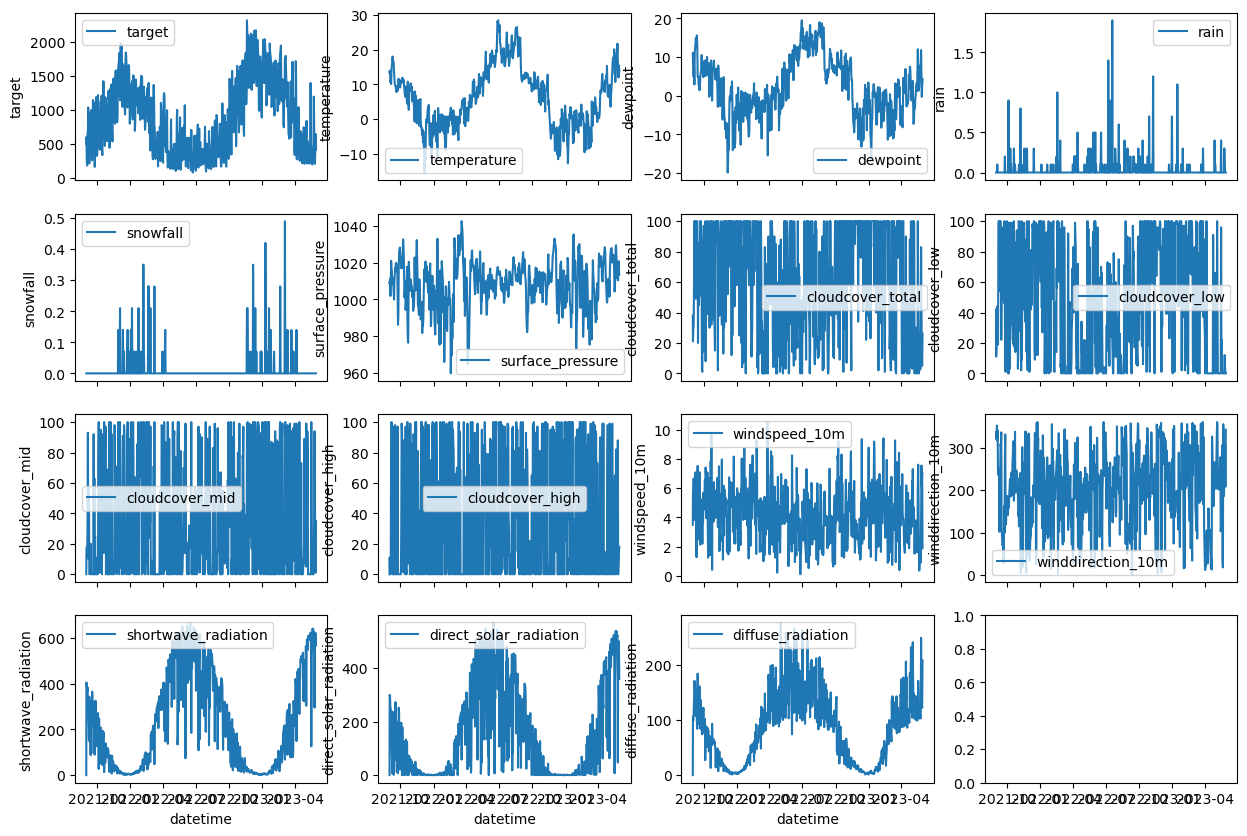

In [26]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_is_consumption_is_business, x='datetime', y=col, label=col, ax=ax)

### 消费且非商用和target相关性

In [27]:
merged_is_consumption_no_business = merged_is_consumption[(merged_is_consumption['county']==0)&(merged_is_consumption['product_type']==1)&(merged_is_consumption['is_business']==0)]
merged_is_consumption_no_business.corr().loc['target']

county                         NaN
data_block_id             0.380721
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.027466
datetime                  0.380721
temperature              -0.668187
dewpoint                 -0.560808
rain                     -0.087425
snowfall                  0.239386
surface_pressure         -0.170852
cloudcover_total          0.337854
cloudcover_low            0.370922
cloudcover_mid            0.209307
cloudcover_high           0.071786
windspeed_10m             0.018912
winddirection_10m         0.089520
shortwave_radiation      -0.602921
direct_solar_radiation   -0.526390
diffuse_radiation        -0.604763
latitude                       NaN
longitude                      NaN
year                      0.305325
month                    -0.023435
day                      -0.038557
Name: target, dtype: float64

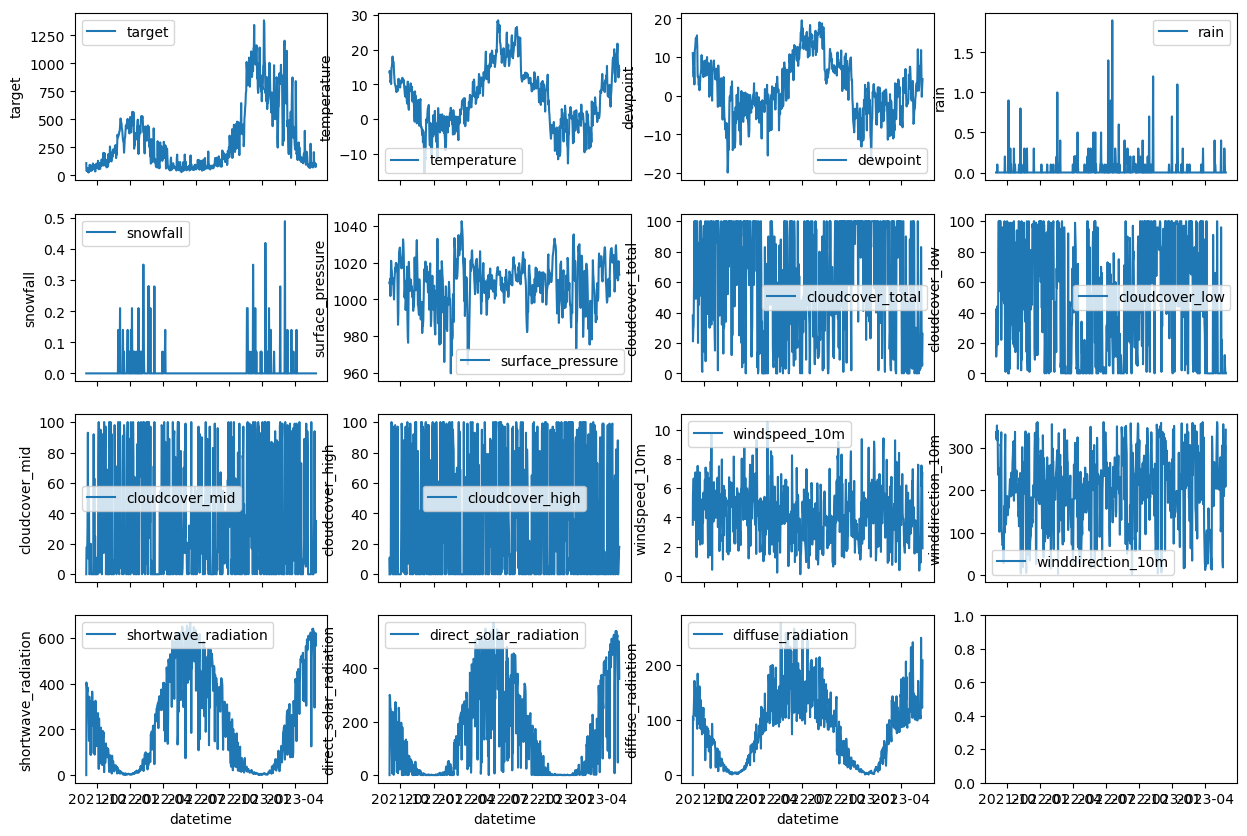

In [28]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_is_consumption_no_business, x='datetime', y=col, label=col, ax=ax)

## 生产target的相关性
### 生产且非商用和target的相关性

In [29]:
merged_no_consumption_no_business = merged_no_consumption[(merged_no_consumption['county']==0)&(merged_no_consumption['product_type']==1)&(merged_no_consumption['is_business']==0)]
merged_no_consumption_no_business.corr().loc['target']

county                         NaN
data_block_id             0.442128
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.032719
datetime                  0.442128
temperature               0.500537
dewpoint                  0.281266
rain                      0.024778
snowfall                 -0.155566
surface_pressure          0.242215
cloudcover_total         -0.383478
cloudcover_low           -0.432832
cloudcover_mid           -0.126396
cloudcover_high          -0.079640
windspeed_10m            -0.172480
winddirection_10m        -0.061817
shortwave_radiation       0.721054
direct_solar_radiation    0.670424
diffuse_radiation         0.611243
latitude                       NaN
longitude                      NaN
year                      0.434836
month                    -0.196700
day                       0.020183
Name: target, dtype: float64

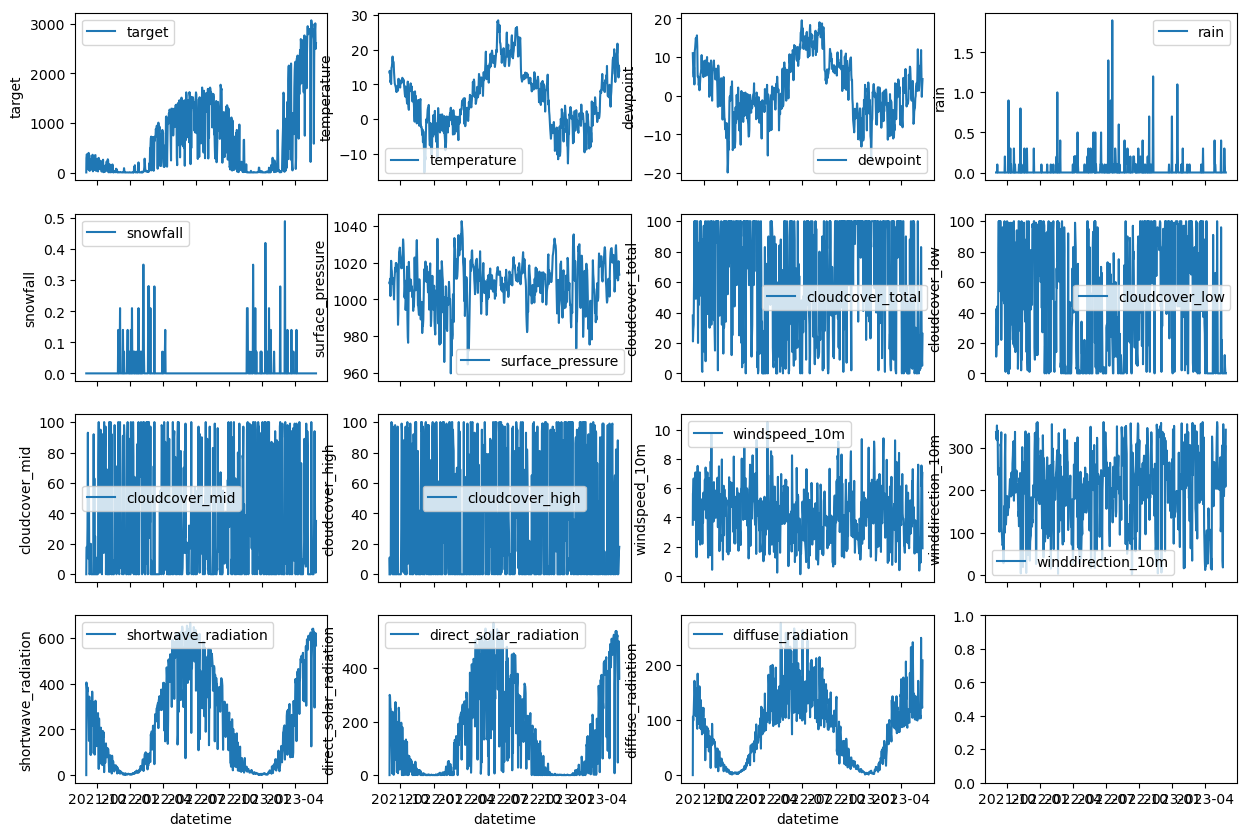

In [30]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_no_consumption_no_business, x='datetime', y=col, label=col, ax=ax)

### 生产且商用和target的相关性

In [31]:
merged_no_consumption_is_business = merged_no_consumption[(merged_no_consumption['county']==0)&(merged_no_consumption['product_type']==1)&(merged_no_consumption['is_business']==1)]
merged_no_consumption_is_business.corr().loc['target']

county                         NaN
data_block_id             0.332007
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.030269
datetime                  0.332006
temperature               0.502461
dewpoint                  0.298985
rain                      0.047685
snowfall                 -0.157677
surface_pressure          0.239716
cloudcover_total         -0.355876
cloudcover_low           -0.411269
cloudcover_mid           -0.113176
cloudcover_high          -0.082519
windspeed_10m            -0.159354
winddirection_10m        -0.051702
shortwave_radiation       0.702080
direct_solar_radiation    0.649743
diffuse_radiation         0.603485
latitude                       NaN
longitude                      NaN
year                      0.331070
month                    -0.157126
day                       0.019769
Name: target, dtype: float64

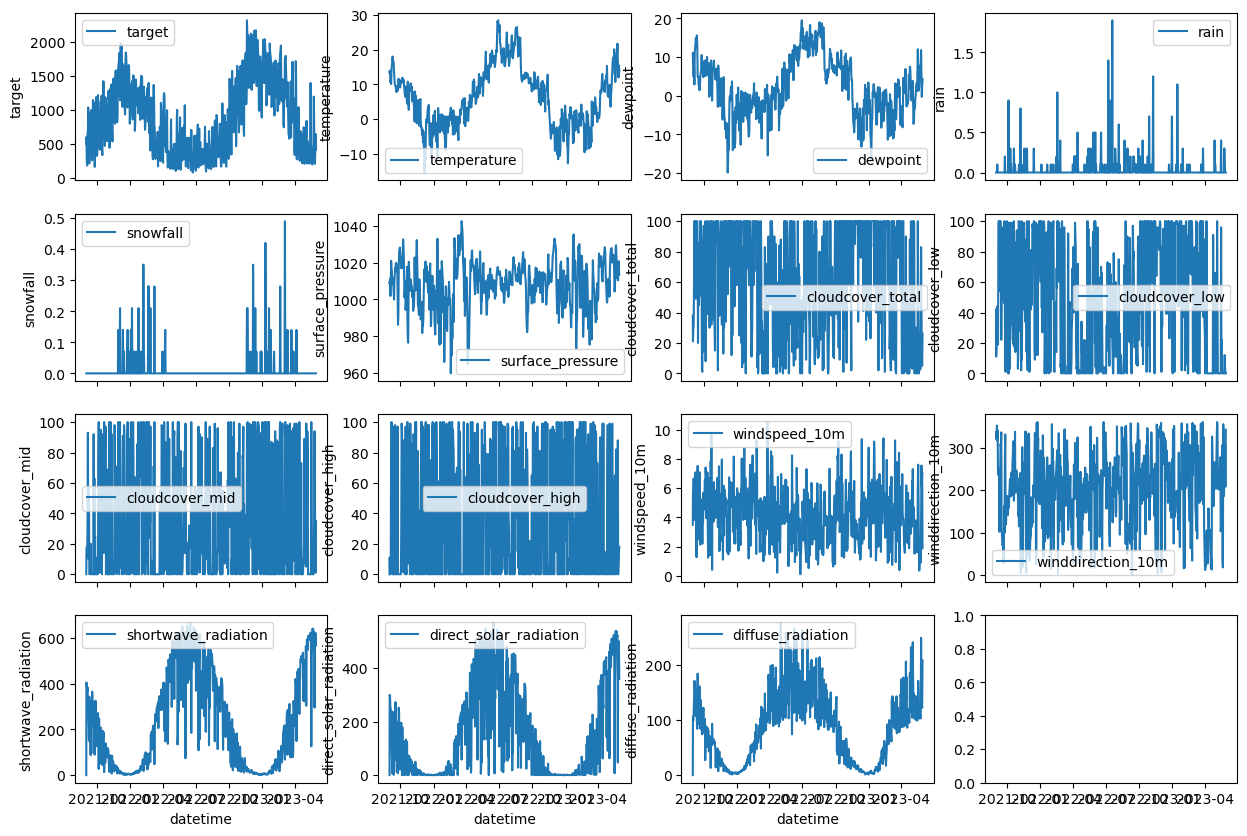

In [32]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_is_consumption_is_business, x='datetime', y=col, label=col, ax=ax)

<Axes: >

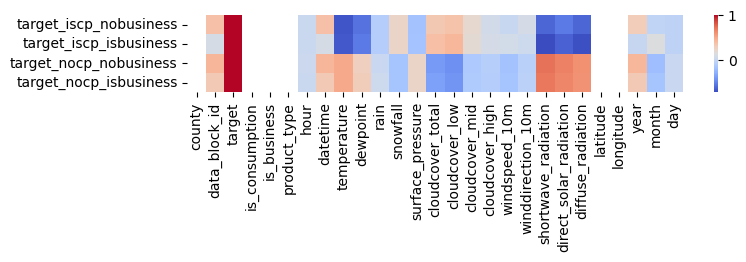

In [33]:
corr_no_consumption_is_business = merged_no_consumption_is_business.corr().loc['target']
corr_no_consumption_no_business = merged_no_consumption_no_business.corr().loc['target']
corr_is_consumption_is_business = merged_is_consumption_is_business.corr().loc['target']
corr_is_consumption_no_business = merged_is_consumption_no_business.corr().loc['target']
plt.figure(figsize=(8,1))
corr_is_consumption_no_business.rename('target_iscp_nobusiness', inplace=True)
corr_is_consumption_is_business.rename('target_iscp_isbusiness', inplace=True)
corr_no_consumption_no_business.rename('target_nocp_nobusiness', inplace=True)
corr_no_consumption_is_business.rename('target_nocp_isbusiness', inplace=True)
corr_data = pd.concat([corr_is_consumption_no_business, corr_is_consumption_is_business, corr_no_consumption_no_business,
                       corr_no_consumption_is_business], axis=1)
sns.heatmap(corr_data.T, cmap='coolwarm')

## 总结
综上，temperature,dewpoint,snowfall,cloudcover_total,cloudcover_low, shortwave_radiation,direct_solar_radiation,diffuse_radiation可作为筛选特征变量

# 预测天气部分

In [34]:
# 读取数据
forcast_weather = pd.read_csv('../data/forecast_weather.csv', parse_dates=['forecast_datetime'])
forcast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [35]:
# 将经纬度乘以10并调整为整数型以减少内存占用
forcast_weather['latitude'] = forcast_weather['latitude']*10
forcast_weather['longitude'] = forcast_weather['longitude']*10
forcast_weather['latitude'] = forcast_weather['latitude'].astype(int)
forcast_weather['longitude'] = forcast_weather['longitude'].astype(int)
forcast_weather['hour'] = forcast_weather['forecast_datetime'].apply(lambda x: x.hour)
forcast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,hour
0,576,217,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
1,576,222,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
2,576,227,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
3,576,232,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
4,576,237,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1


In [36]:
# 拼接前的预测天气数据
len(forcast_weather)

3424512

In [37]:
# 筛选hours_ahead小于24的数据，即预测跨度为一天的数据
forcast_weather = forcast_weather[forcast_weather['hours_ahead'] >= 24]
len(forcast_weather)

1783600

In [38]:
# 对数据按照经纬度拼接
forcast_weather = pd.merge(left=forcast_weather, right=location, on=['latitude', 'longitude'])
# forcast_weather.drop_duplicates(subset=['county', 'origin_datetime'], inplace=True)
forcast_weather['county'].unique()
# 经过观察拼接后的county缺少了12

array([10, 15,  7, 13, 14, 11,  8,  4,  1,  6,  9,  3,  0,  5,  2],
      dtype=int64)

In [39]:
train_with_forecast_weather = pd.merge(left=train, right=forcast_weather, on=['county', 'data_block_id', 'hour'], how='left')
train_with_forecast_weather.drop_duplicates(subset=['row_id'], inplace=True)
train_with_forecast_weather

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11263779,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263784,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263789,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263794,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0


In [40]:
len(train)

2018352

In [41]:
len(train_with_forecast_weather)

2018352

In [42]:
# 查看拼接后数据的缺失值情况
train_with_forecast_weather.isnull().sum()

county                                   0
is_business                              0
product_type                             0
target                                 528
is_consumption                           0
datetime                                 0
data_block_id                            0
row_id                                   0
prediction_unit_id                       0
year                                     0
month                                    0
day                                      0
hour                                     0
latitude                             33504
longitude                            33504
origin_datetime                      33504
hours_ahead                          33504
temperature                          33504
dewpoint                             33504
cloudcover_high                      33504
cloudcover_low                       33504
cloudcover_mid                       33504
cloudcover_total                     33504
10_metre_u_

In [43]:
# 删除缺失值
train_with_forecast_weather.dropna(how='any', inplace=True)
train_with_forecast_weather.drop(columns=['forecast_datetime', 'origin_datetime'], inplace=True)

## 生产电量与预测天气的相关性
以county=2, product_type=1为例

### 商业生产电量与预测天气的相关性

In [45]:
train_forecast_no_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==0) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 1)]
corr_no_consumption_is_business = train_forecast_no_consumption.corr()['target']
corr_no_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.024407
data_block_id                        0.024219
row_id                               0.023588
prediction_unit_id                        NaN
year                                -0.003156
month                                0.040172
day                                  0.022450
hour                                 0.097135
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.097135
temperature                          0.528462
dewpoint                             0.268787
cloudcover_high                     -0.097232
cloudcover_low                      -0.307835
cloudcover_mid                      -0.133898
cloudcover_total                  

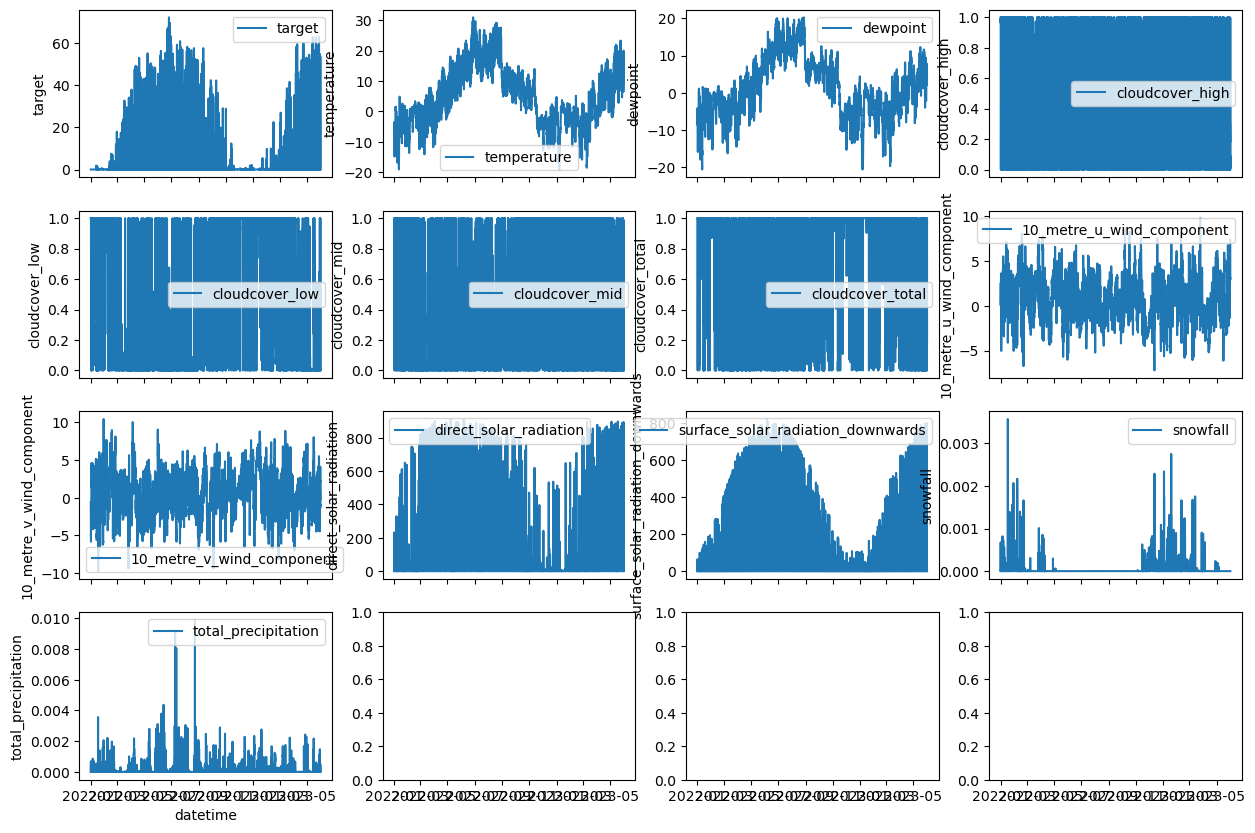

In [46]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_no_consumption, x='datetime', y=col, label=col, ax=ax)

### 非商业生产电量与预测天气的相关性

In [47]:
train_forecast_no_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==0) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 0)]
corr_no_consumption_no_business = train_forecast_no_consumption.corr()['target']
corr_no_consumption_no_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.221966
data_block_id                        0.221865
row_id                               0.221025
prediction_unit_id                        NaN
year                                 0.214308
month                               -0.087302
day                                  0.019014
hour                                 0.061406
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.061406
temperature                          0.471169
dewpoint                             0.219349
cloudcover_high                     -0.092600
cloudcover_low                      -0.294572
cloudcover_mid                      -0.113685
cloudcover_total                  

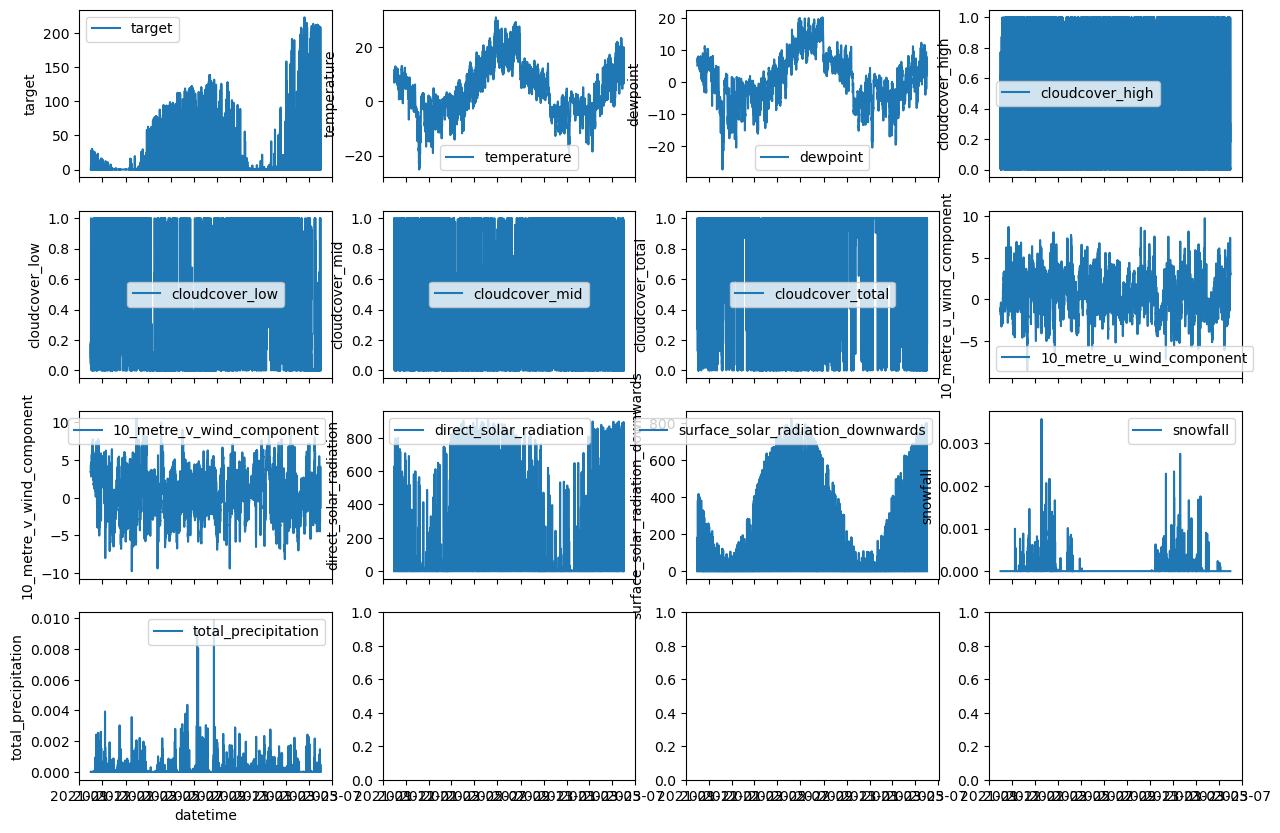

In [48]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_no_consumption, x='datetime', y=col, label=col, ax=ax)

## 消费电量与预测天气的相关性

### 商业消费电量与预测天气的相关性

In [49]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==1) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 1)]
corr_is_consumption_is_business = train_forecast_is_consumption.corr()['target']
corr_is_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.187615
data_block_id                        0.187504
row_id                               0.188059
prediction_unit_id                        NaN
year                                 0.199295
month                               -0.044960
day                                 -0.060847
hour                                 0.057416
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.057416
temperature                         -0.397307
dewpoint                            -0.429379
cloudcover_high                      0.011089
cloudcover_low                       0.150954
cloudcover_mid                       0.104484
cloudcover_total                  

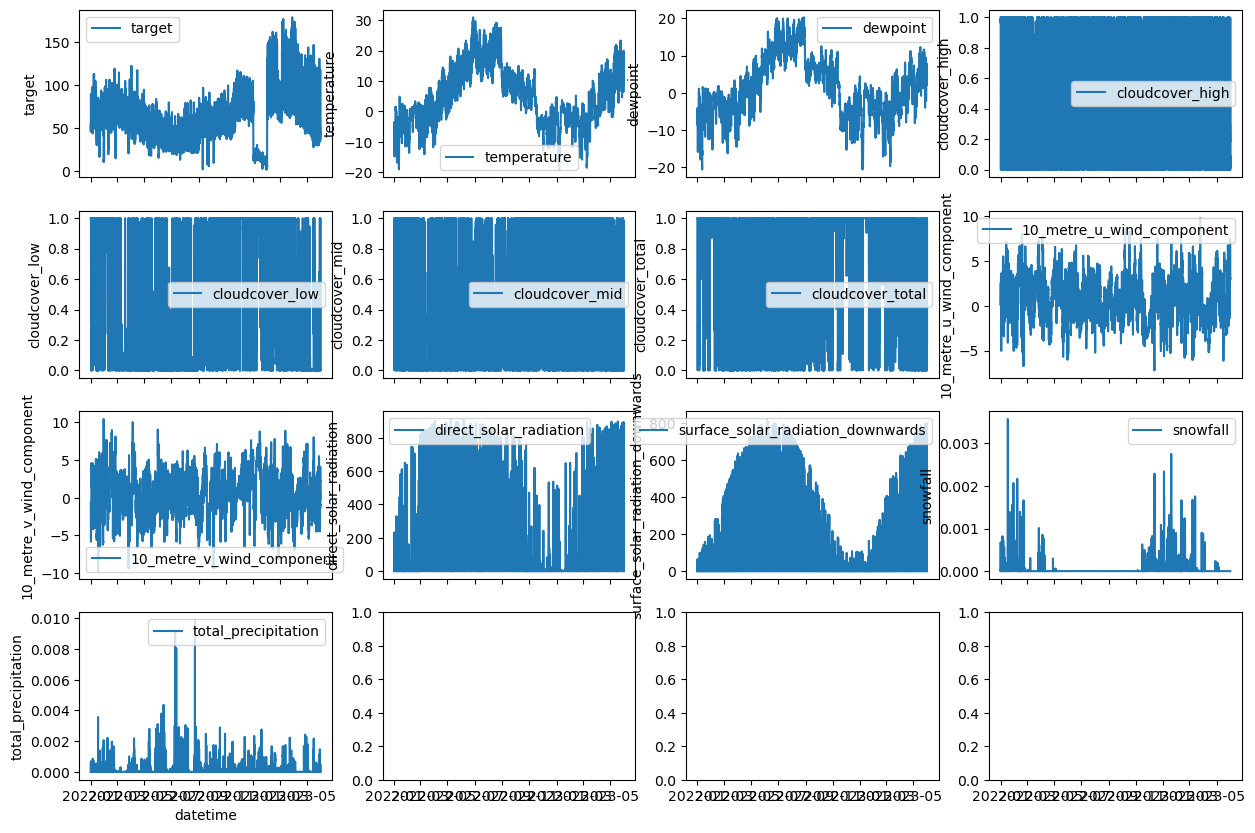

In [50]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_is_consumption, x='datetime', y=col, label=col, ax=ax)

### 非商业消费电量与预测天气的相关性

In [51]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==1) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 0)]
corr_is_consumption_no_business = train_forecast_is_consumption.corr()['target']
corr_is_consumption_no_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.518004
data_block_id                        0.517886
row_id                               0.519506
prediction_unit_id                        NaN
year                                 0.472839
month                               -0.146909
day                                 -0.054073
hour                                 0.071991
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.071991
temperature                         -0.594492
dewpoint                            -0.517949
cloudcover_high                      0.077881
cloudcover_low                       0.315915
cloudcover_mid                       0.154951
cloudcover_total                  

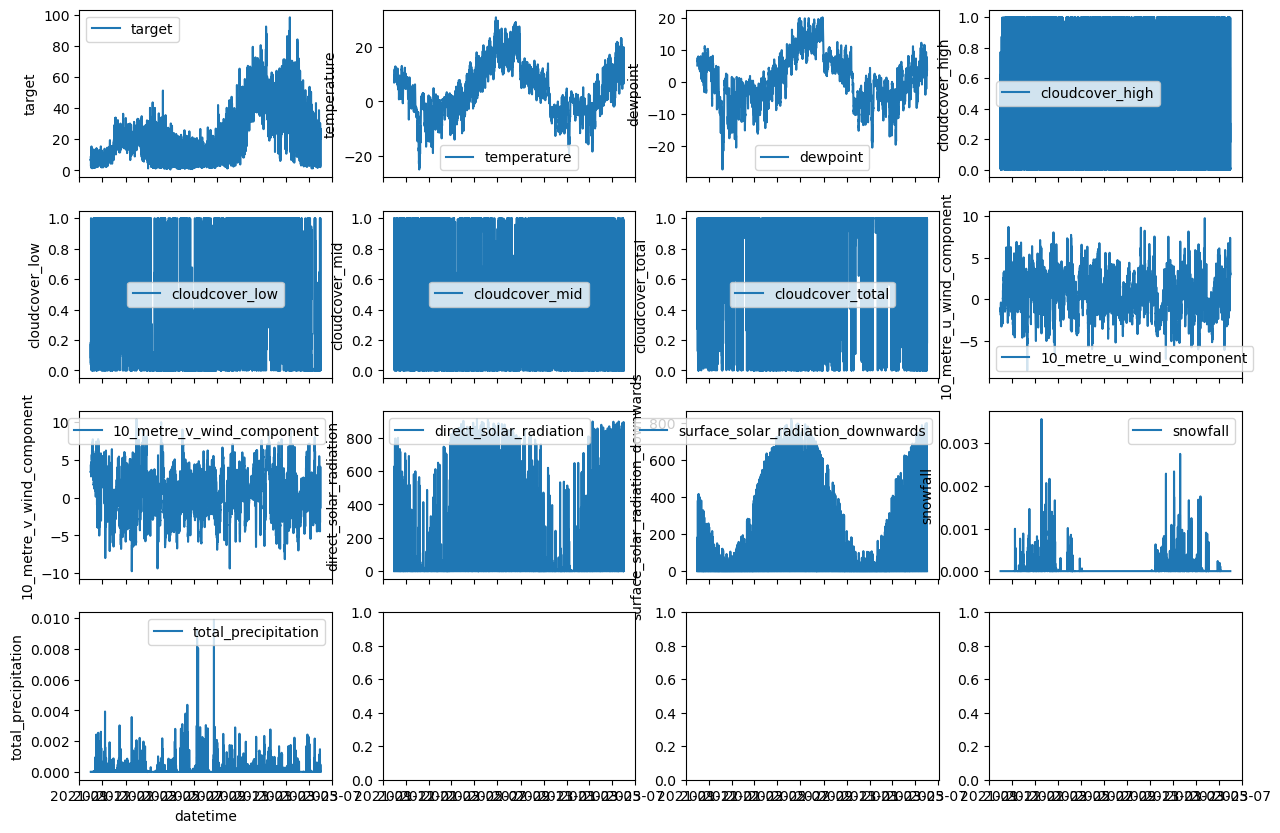

In [52]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_is_consumption, x='datetime', y=col, label=col, ax=ax)

<Axes: >

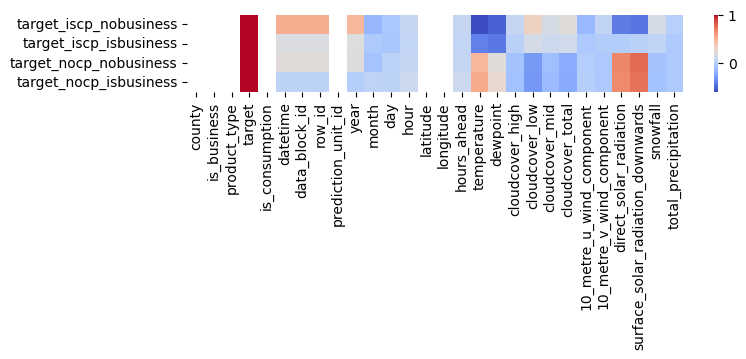

In [53]:
plt.figure(figsize=(8,1))
corr_is_consumption_no_business.rename('target_iscp_nobusiness', inplace=True)
corr_is_consumption_is_business.rename('target_iscp_isbusiness', inplace=True)
corr_no_consumption_no_business.rename('target_nocp_nobusiness', inplace=True)
corr_no_consumption_is_business.rename('target_nocp_isbusiness', inplace=True)
corr_data = pd.concat([corr_is_consumption_no_business, corr_is_consumption_is_business, corr_no_consumption_no_business, 
                       corr_no_consumption_is_business], axis=1)
sns.heatmap(corr_data.T, cmap='coolwarm')

## 总结
综上, temperature, dewpoint, cloudcover_low, cloudcover_total, direct_solar_radiation, surface_solar_radiation_downwards, snowfall可作为筛选后特征变量